# How to Train Your Own Key Points Detection Networks

![](https://user-images.githubusercontent.com/22118253/69765965-fd65a700-1143-11ea-8804-cd1d33f2e824.png)

In this notebook, we will demonstrate 
- how to train your own KeyPoints detection network and do inference on pictures of traffic cone.

**[Accurate Low Latency Visual Perception for Autonomous Racing: Challenges Mechanisms and Practical Solutions](https://github.com/mit-han-lab/once-for-all)** is an accurate low latency visual perception system introduced by Kieran Strobel, Sibo Zhu, Raphael Chang, and Skanda Koppula.


## 1. Preparation
Let's first install all the required packages:

In [ ]:
! sudo apt install unzip
print('Installing numpy...')
! pip3 install numpy 
# tqdm is a package for displaying a progress bar.
print('Installing tqdm (progress bar) ...')
! pip3 install tqdm 
print('Installing matplotlib...')
! pip3 install matplotlib 
print('Installing dataset reader...')
! pip3 install pandas

Let' s clone our repo first...

In [18]:
# ! git clone https://github.com/cv-core/MIT-Driverless-CV-TrainingInfra.git

# ! mv MIT-Driverless-CV-TrainingInfra/RektNet/* .

Before we start training, let's download the Cone Detection dataset and the corresponding label and intial training weights. 

In [19]:
print("Downloading Training Dataset")
! wget https://storage.googleapis.com/mit-driverless-open-source/RektNet_Dataset.zip
! unzip -q RektNet_Dataset.zip
! mv RektNet_Dataset dataset/ && rm RektNet_Dataset.zip
print("Downloading Training and Validation Label")
! cd dataset/ && wget https://storage.googleapis.com/mit-driverless-open-source/rektnet-training/mini_rektnet_label.csv && mv mini_rektnet_label.csv rektnet_label.csv && cd ..

## 2. Training


First, import all the packages used in this tutorial:

In [20]:
import argparse
import tempfile
import sys
import os
import multiprocessing
import shutil
from tqdm import tqdm
import numpy as np
import cv2
import copy
from datetime import datetime
from tqdm import tqdm

import PIL
from PIL import Image, ImageDraw

import torch
from torch.autograd import Variable
from torch.backends import cudnn
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

from keypoint_net import KeypointNet
from cross_ratio_loss import CrossRatioLoss
from utils import Logger
from utils import load_train_csv_dataset, prep_image, visualize_data, vis_tensor_and_save, calculate_distance, calculate_mean_distance
from dataset import ConeDataset
from keypoint_tutorial_util import print_tensor_stats, eval_model, print_kpt_L2_distance

cv2.setRNGSeed(17)
torch.manual_seed(17)
np.random.seed(17)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

visualization_tmp_path = "/outputs/visualization/"

Successfully imported all packages and configured random seed to 17!

Training Config

In [33]:

study_name="tutorial"

current_month = datetime.now().strftime('%B').lower()
current_year = str(datetime.now().year)
if not os.path.exists(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')):
    os.makedirs(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/'))
output_uri = os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')

save_file_name = 'logs/' + output_uri.split('/')[-2]
sys.stdout = Logger(save_file_name + '.log')
sys.stderr = Logger(save_file_name + '.error')

INPUT_SIZE = (80, 80)
KPT_KEYS = ["top", "mid_L_top", "mid_R_top", "mid_L_bot", "mid_R_bot", "bot_L", "bot_R"]

intervals = int(2) # for normal training, set it to 4
val_split = float(0.15)

batch_size= int(32)
num_epochs= int(4) # for normal training, set it to 1024

# Load the train data.
train_csv = "dataset/rektnet_label.csv"
dataset_path = "dataset/RektNet_Dataset/"
vis_dataloader = False
save_checkpoints = True
save_checkpoints=True
evaluate_mode=False
lr = 1e-1
lr_gamma = 0.999
geo_loss = True
geo_loss_gamma_vert = 0
geo_loss_gamma_horz = 0
loss_type = "l1_softargmax"
best_val_loss = float('inf')
best_epoch = 0
max_tolerance = 8
tolerance = 0
num_kpt=len(KPT_KEYS)

Create pytorch dataloaders for train and validation sets.

In [34]:
train_images, train_labels, val_images, val_labels = load_train_csv_dataset(train_csv, validation_percent=val_split, keypoint_keys=KPT_KEYS, dataset_path=dataset_path, cache_location="./gs/")

train_dataset = ConeDataset(images=train_images, labels=train_labels, dataset_path=dataset_path, target_image_size=INPUT_SIZE, save_checkpoints=save_checkpoints, vis_dataloader=vis_dataloader)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=False, num_workers=0)
val_dataset = ConeDataset(images=val_images, labels=val_labels, dataset_path=dataset_path, target_image_size=INPUT_SIZE, save_checkpoints=save_checkpoints, vis_dataloader=vis_dataloader)
val_dataloader = DataLoader(val_dataset, batch_size= 1, shuffle=False, num_workers=0)

Define model, optimizer and loss function.

In [35]:
model = KeypointNet(len(KPT_KEYS), INPUT_SIZE, onnx_mode=False)
model = model.to(device)
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_gamma)
loss_func = CrossRatioLoss(loss_type, geo_loss, geo_loss_gamma_horz, geo_loss_gamma_vert)

In [36]:
for epoch in range(num_epochs):
    print(f"EPOCH {epoch}")
    model.train()
    total_loss = [0,0,0] # location/geometric/total
    batch_num = 0

    train_process = tqdm(train_dataloader)
    for x_batch, y_hm_batch, y_points_batch, image_name, _ in train_process:
        x_batch = x_batch.to(device, non_blocking=True)
        y_hm_batch = y_hm_batch.to(device, non_blocking=True)
        y_points_batch = y_points_batch.to(device, non_blocking=True)

        # Zero the gradients.
        if optimizer is not None:
            optimizer.zero_grad()

        # Compute output and loss.
        output = model(x_batch)
        loc_loss, geo_loss, loss = loss_func(output[0], output[1], y_hm_batch, y_points_batch)
        loss.backward()
        optimizer.step()

        loc_loss, geo_loss, loss = loc_loss.item(), geo_loss.item(), loss.item()
        train_process.set_description(f"Batch {batch_num}. Location Loss: {round(loc_loss,5)}. Geo Loss: {round(geo_loss,5)}. Total Loss: {round(loss,5)}")
        total_loss[0] += loc_loss
        total_loss[1] += geo_loss
        total_loss[2] += loss
        batch_num += 1

    print(f"\tTraining: MSE/Geometric/Total Loss: {round(total_loss[0]/batch_num,10)}/{round(total_loss[1]/batch_num,10)}/{round(total_loss[2]/batch_num,10)}")
    val_loc_loss, val_geo_loss, val_loss = eval_model(model=model, dataloader=val_dataloader, loss_function=loss_func, input_size=INPUT_SIZE)

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        tolerance = 0
    else:
        tolerance += 1

    if save_checkpoints and epoch != 0 and (epoch + 1) % intervals == 0:
        # Save the latest weights
        gs_pt_uri = os.path.join(output_uri, "{epoch}_loss_{loss}.pt".format(epoch=epoch, loss=round(val_loss, 2)))
        print(f'Saving model to {gs_pt_uri}')
        checkpoint = {'epoch': epoch,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, gs_pt_uri)
    if tolerance >= max_tolerance:
        print(f"Training is stopped due; loss no longer decreases. Epoch {best_epoch} is has the best validation loss.")
        break

## 3. Inference

Download target image file for inference

Text(0.5, 1.0, 'Keypoints Detection Result')

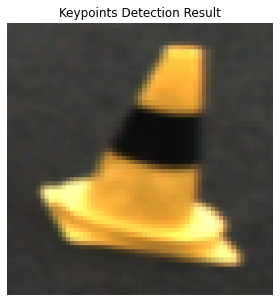

In [25]:
! wget https://storage.googleapis.com/mit-driverless-open-source/test_kpt.png
    
import cv2
%matplotlib inline
import matplotlib.pylab as pt

image = cv2.imread("test_kpt.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pt.fig = pt.figure(figsize=(5, 5))

pt.imshow(image)
pt.axis('off')
pt.title('Keypoints Detection Result')

Download pretrained weights for inference

In [26]:
! wget https://storage.googleapis.com/mit-driverless-open-source/pretrained_kpt.pt

Set up config file for inference

In [27]:
model = "pretrained_kpt.pt"
img = "test_kpt.png"
img_size = int(80)
output = "outputs/visualization/"
flip = False
rotate = False

Prepared Image

In [28]:
output_path = output
model_filepath = model
image_filepath = img

img_name = '_'.join(image_filepath.split('/')[-1].split('.')[0].split('_')[-5:])

image_size = (img_size, img_size)

image = cv2.imread(image_filepath)

image = prep_image(image=image,target_image_size=image_size)
image = (image.transpose((2, 0, 1)) / 255.0)[np.newaxis, :]
image = torch.from_numpy(image).type('torch.FloatTensor')

In [29]:
model = KeypointNet()
model.load_state_dict(torch.load(model_filepath).get('model'))
model.eval()
output = model(image)
out = np.empty(shape=(0, output[0][0].shape[2]))
for o in output[0][0]:
    chan = np.array(o.cpu().data)
    cmin = chan.min()
    cmax = chan.max()
    chan -= cmin
    chan /= cmax - cmin
    out = np.concatenate((out, chan), axis=0)
cv2.imwrite(output_path + img_name + "_hm.jpg", out * 255)

True

In [30]:
image = cv2.imread(image_filepath)
h, w, _ = image.shape

image = vis_tensor_and_save(image=image, h=h, w=w, tensor_output=output[1][0].cpu().data, image_name=img_name, output_uri=output_path)

In [31]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Keypoints Detection Result')

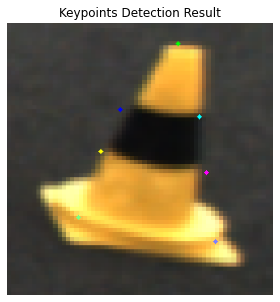

In [32]:
pt.fig = pt.figure(figsize=(5, 5))

pt.imshow(image)
pt.axis('off')
pt.title('Keypoints Detection Result')

Congratulations! You've finished all the content of this tutorial!
Hope you enjoy playing with the our object detection model. If you are interested,  please refer to our paper and GitHub Repo for further details.

## Reference
[1] Kieran Strobel, Sibo Zhu, Raphael Chang and Skanda Koppula.
**Accurate, Low-Latency Visual Perception for Autonomous Racing:Challenges, Mechanisms, and Practical Solutions**. In *IROS* 2020.
[[paper]](https://arxiv.org/abs/2007.13971), [[code]](https://github.com/cv-core/MIT-Driverless-CV-TrainingInfra).